<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/classificacao_redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando a biblioteca `graph-tool`(https://graph-tool.skewed.de)

---

In [1]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://downloads.skewed.de/apt jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 261 kB in 20s (12.8 kB/s)
Read

In [2]:
# O Colab usa uma instalação Python diferente da do sistema! Colaboração ruim! Precisamos de algumas soluções alternativas.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 50 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 131082 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.
  Using cached pycairo-1.26.0-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pycairo
    Found existing installation: pycairo 1.26.0
    Uninstalling pycairo-1.26.0:
      Successfully uninstalled pycairo-1.26.0


### Agora podemos usar a ferramenta gráfica como qualquer outro módulo Python

In [3]:
import graph_tool.all as gt

# Classificação de redes complexa
---

Selecione 3 redes biológicas, 3 redes sociais e 3 redes tecnológicas desses endereços:

https://networks.skewed.de

http://konect.cc/networks/

https://icon.colorado.edu/

Faça a classificação das redes usando os modelos e medidas que aprendemos na aula.

Não se esqueça de selecionar o mesmo N e grau médio que a rede original na construção dos modelos.

Verifique qual o modelo mais adequado para cada rede.

**Hipótese:** Redes do mesmo tipo seguem o mesmo modelo. Verifique se essa hipótese é verdadeira.

**Bônus (não é obrigatório):** Identifique as principais diferenças entre os modelos. Isto é, quais medidas mais contribuem para que uma rede seja classificada como sendo do
modelo BA

Site utilizado: https://networks.skewed.de

https://networks.skewed.de/net/celegans_2019 (celegans_2019/hermaphrodite_gap_junction)

https://networks.skewed.de/net/yeast_transcription (yeast_transcription)

https://networks.skewed.de/net/foodweb_little_rock (foodweb_little_rock)

### Importando bibliotecas

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.inspection import permutation_importance

Vamos inicialmente trabalhar com a rede `celegans_2019/hermaphrodite_gap_junction`.

Número de nós: 460
Número de arestas: 1428


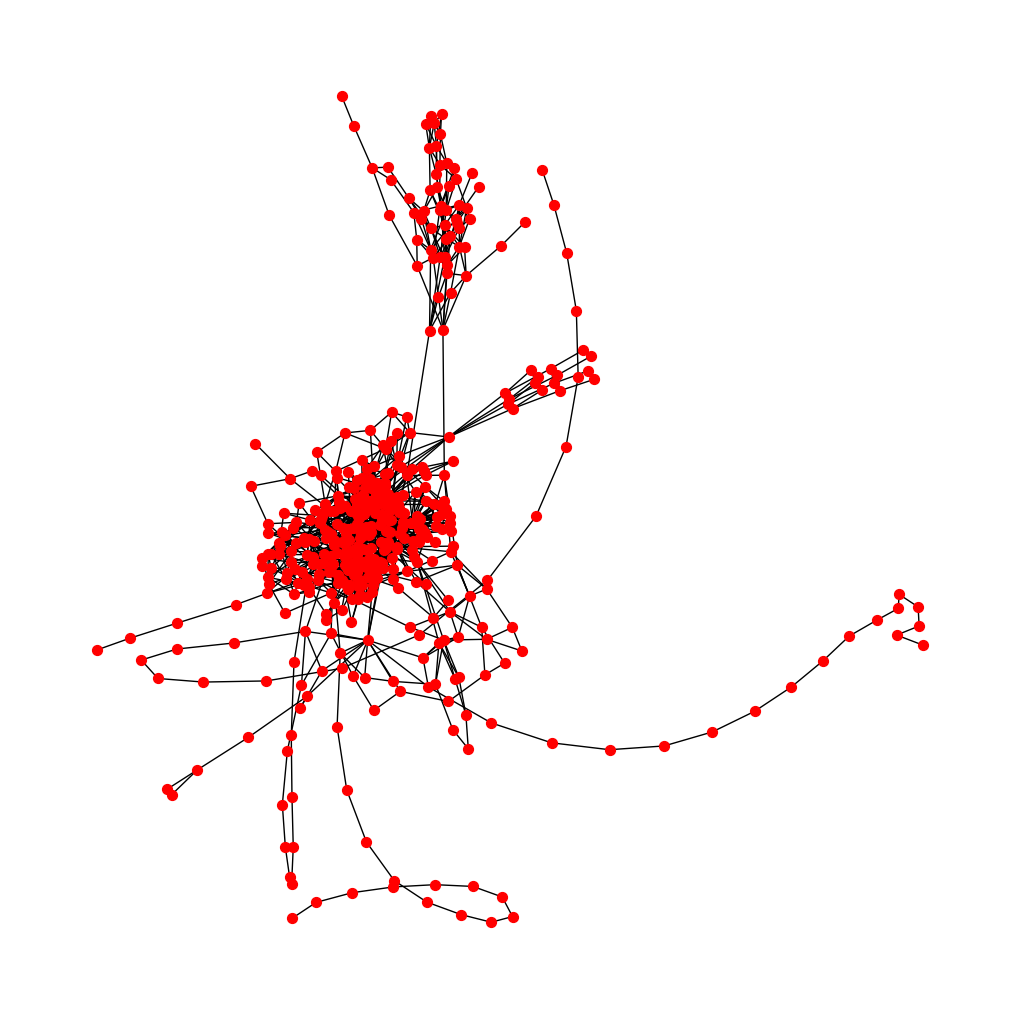

In [5]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["celegans_2019/hermaphrodite_gap_junction"]

# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="red", node_size=50, with_labels=False)
plt.show()

### Definindo features

Vamos criar uma função que calcule todas as features que desejamos utilizar como atributos em nossos modelos.

- **k1:** Primeiro momento do grau;
- **k2:** Segundo momento do grau;
- **variance:** Variância;
- **av_cl:** Average Clustering;
- **l:** Average shortest path length;
- **r:** Grau do coeficiente de assortatividade;
- **H:** Entropia de Shannon;
- **av_B:**
- **av_knn:**

In [6]:
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # Pegamos apenas os valores dos graus
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues = np.arange(0, maxk + 1)  # Valores possíveis de k

    Pk = np.zeros(maxk + 1)  # P(k)
    for k in vk:
        Pk[k] += 1
    Pk = Pk / sum(Pk)  # A soma dos elementos de P(k) deve ser igual a um

    return kvalues, Pk

def measures(G):
    def momment_of_degree_distribution(G, m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M += G.degree(i) ** m
        M /= N
        return M

    def shannon_entropy(G):
        k, Pk = degree_distribution(G)
        H = 0
        for p in Pk:
            if p > 0:
                H -= p * math.log(p, 2)
        return H

    knn = []
    for i in G.nodes():
        aux = nx.average_neighbor_degree(G, nodes=[i])
        knn.append(float(aux[i]))
    knn = np.array(knn)
    av_knn = np.mean(knn)

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G, 1)
    k2 = momment_of_degree_distribution(G, 2)
    variance = momment_of_degree_distribution(G, 2) - momment_of_degree_distribution(G, 1) ** 2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r = nx.degree_assortativity_coefficient(G)
    H = shannon_entropy(G)
    B = dict(nx.betweenness_centrality(G))
    B = list(B.values())
    av_B = np.mean(B)

    return k1, k2, variance, av_cl, l, r, H, av_B, av_knn

Uma vez criada a função com as features que desejamos utilizar, bastar chamarmos a função para que possamos calcular as features referente a rede selecionada.

### Distribuição do grau

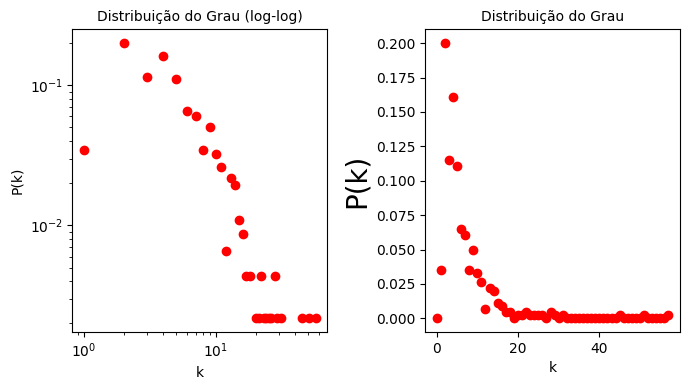

In [7]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de Futures

In [8]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[6.208695652173913, 74.63478260869566, 36.08688090737241, 0.19217001911445616, 6.461788386852326, 0.13592733142912006, 3.7104219007213315, 0.011925302154699401, 9.836670631788124]


### Criando as redes complexas

Vamos criar uma função que gere modelos de redes complexas atrelados as features que definimos acima. Além disso, vamos acoplar um classificador o qual nos dirá qual o modelo de rede o modelo de classificação identificou.

In [9]:
def generate_network_data(N, av_degree, n_nets):
    cl = ["ER", "WS", "BA", "WS__", "WG"]
    X = []
    y = []
    p = av_degree/(N - 1)

    # ER networks
    for i in range(n_nets):
        GER = nx.gnp_random_graph(N, p, seed=(42 + i), directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(GER)
        x = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
        X.append(x)
        y.append(0.0)

    # WS networks
    k = int(av_degree)
    p_ = 0.1  # probability of rewiring
    for i in range(n_nets):
        GWS = nx.watts_strogatz_graph(N, k, p_, seed=(42 + i))
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(GWS)
        x = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
        X.append(x)
        y.append(1.0)

    # BA networks
    m = int(av_degree/2)
    for i in range(n_nets):
        GBA = nx.barabasi_albert_graph(N, m)
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(GBA)
        x = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
        X.append(x)
        y.append(2.0)

    # WS__ networks
    k = int(av_degree)
    p__ = 0.3
    for i in range(n_nets):
        GWS__ = nx.watts_strogatz_graph(N, k, p__, seed=(42 + i))
        Gcc = sorted(nx.connected_components(GWS__), key=len, reverse=True)
        GWS__ = GWS__.subgraph(Gcc[0])
        GWS__ = nx.convert_node_labels_to_integers(GWS__, first_label=0)
        k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(GWS__)
        x = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
        X.append(x)
        y.append(3.0)

    # WG networks (Waxman)
    m = int(av_degree/2)
    for i in range(n_nets):
        GWX = nx.waxman_graph(N, seed=(42 + i))
        Gcc = sorted(nx.connected_components(GWX), key=len, reverse=True)
        GWX = GWX.subgraph(Gcc[0])
        GWX = nx.convert_node_labels_to_integers(GWX, first_label=0)
        k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(GWX)
        x = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
        X.append(x)
        y.append(4.0)

    X = np.array(X)
    y = np.array(y)

    return X, y, cl

### Aplicando a função de modelos de rede

In [10]:
# Parâmetros
N = len(G_nx)   # Número de nós
n_nets = 100    # Número de redes
av_degree = k1  # Grau médio

X = None
y = None

# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Função para calcular a acurácia da classificação da rede

In [11]:
# Testando a acurácia dos modelos
def accuracy_models(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                        test_size = 0.3, shuffle = True,
                                                        random_state = 42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    # KNN
    k = 5
    model1 = KNeighborsClassifier(n_neighbors = k, metric = "euclidean")
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    score1 = accuracy_score(y_pred1, y_test)

    # Regressao Logistica
    model2 = LogisticRegression(solver = "lbfgs", max_iter = 1000)
    model2.fit(X_train, y_train)
    y_pred2 = model2.predict(X_test)
    score2 = accuracy_score(y_pred2, y_test)

    # Naive Bayes
    model3 = GaussianNB()
    model3.fit(X_train, y_train)
    y_pred3 = model3.predict(X_test)
    score3 = accuracy_score(y_pred3, y_test)

    return score1, score2, score3

### Aplicando a função para calcular a acurácia das redes geradas

In [12]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Função para a classificação da rede

In [13]:
def predicao_modelos(X, y, X_rede):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_rede = np.array(X_rede)
    X_rede = X_rede.reshape(1, len(X_rede))
    X_rede = scaler.transform(X_rede)
    print("X_rede:", X_rede.shape)

    # KNN
    k = 5
    model1 = KNeighborsClassifier(n_neighbors = k, metric = "euclidean")
    model1.fit(X,y)
    y_pred1 = model1.predict(X_rede)
    pred1 = cl[int(y_pred1.item())]

    model2 = LogisticRegression(solver = "lbfgs", max_iter = 1000)
    model2.fit(X, y)
    y_pred2 = model2.predict(X_rede)
    pred2 = cl[int(y_pred2.item())]

    model3 = GaussianNB()
    model3.fit(X, y)
    y_pred3 = model3.predict(X_rede)
    pred3 = cl[int(y_pred3.item())]

    return pred1, pred2, pred3

### Aplicando a função de classificação de rede

In [14]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: WS
Pred LR: WS
Pred NB: ER


Devido ao fato de que nenhum dos modelos classificou a rede selecionada como uma rede BA (Barabási-Albert), neste momento não realizaremos a avaliação das features que mais impactam essa classificação.

# Rede `yeast_transcription`

Número de nós: 664
Número de arestas: 1065


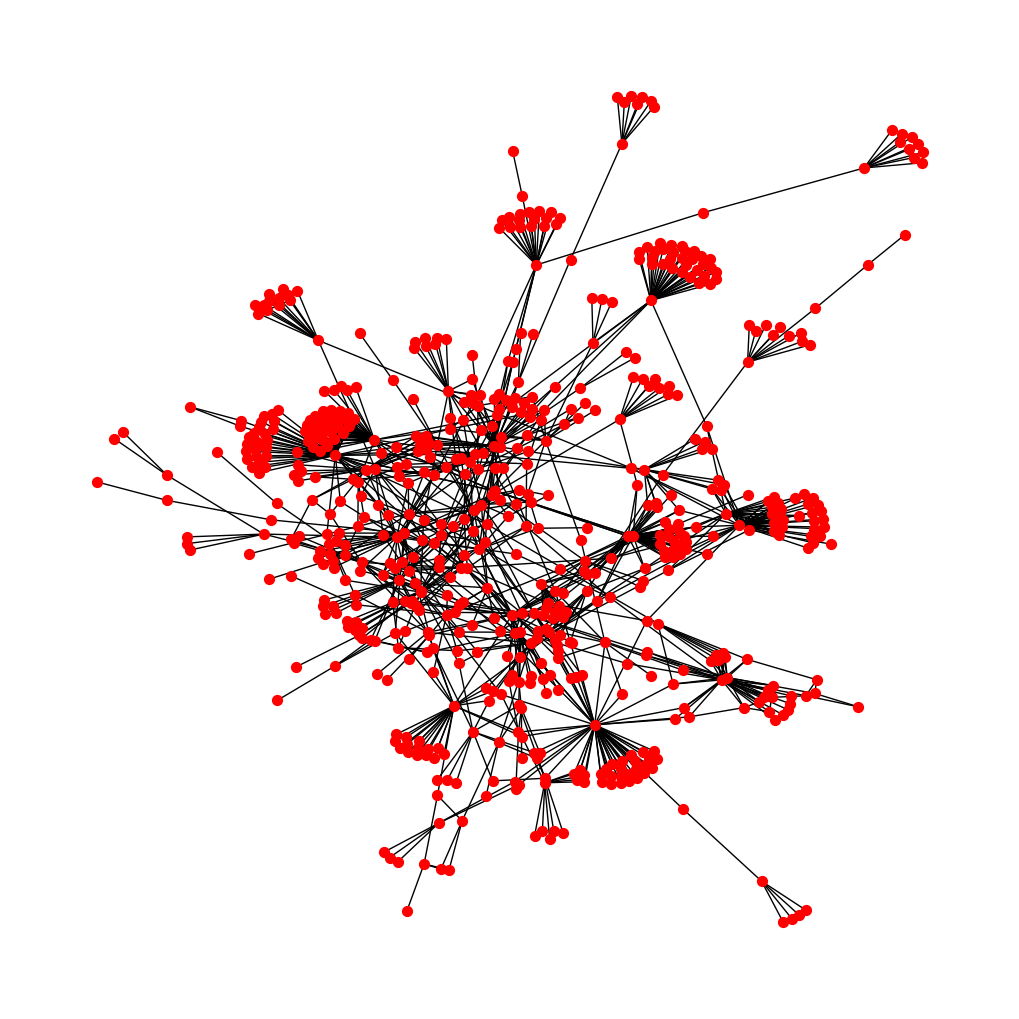

In [15]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["yeast_transcription"]

# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="red", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

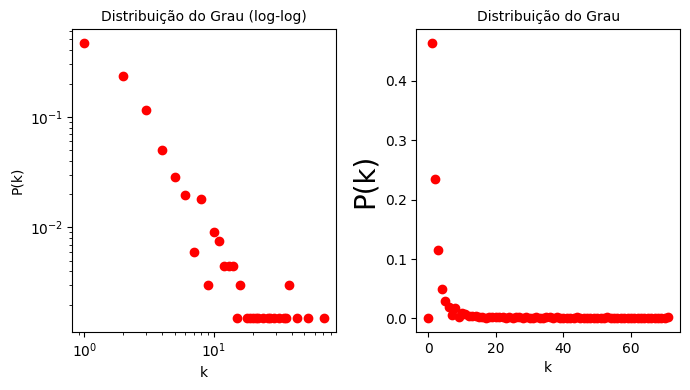

In [16]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [17]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[3.2078313253012047, 43.286144578313255, 32.99596276672957, 0.048817590830936314, 5.200239873521234, -0.4083912916261682, 2.509195248614929, 0.006344773222841743, 22.250447484301038]


### Aplicando a função de modelos de redes

In [18]:
# Parâmetros
N = len(G_nx)   # Número de nós
n_nets = 100    # Número de redes
av_degree = k1  # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [19]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [20]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: BA
Pred LR: BA
Pred NB: WG


Observe que dois modelos classificaram a rede como BA (Barabási-Albert) e um modelo a classificou como WG (Waxman). Vamos analisar quais features mais contribuíram para essas classificações. Para isso, definiremos uma função que gera um gráfico dessas contribuições.

### Função para encontrar a importância das features

In [21]:
def predicao_modelos_importance(X, y, x_rede, cl):
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    x_rede = np.array(x_rede)
    x_rede = x_rede.reshape(1, len(x_rede))
    x_rede = scaler.transform(x_rede)

    feat = ["k1", "k2", "variance", "av_cl", "l", "r", "H", "av_B", "av_knn"]

    k = 5
    model1 = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    model1.fit(X, y)
    y_pred1 = model1.predict(x_rede)
    pred1 = cl[int(y_pred1.item())]

    model2 = LogisticRegression(solver="lbfgs", max_iter=1000)
    model2.fit(X, y)
    y_pred2 = model2.predict(x_rede)
    pred2 = cl[int(y_pred2.item())]

    model3 = GaussianNB()
    model3.fit(X, y)
    y_pred3 = model3.predict(x_rede)
    pred3 = cl[int(y_pred3.item())]

    # Importância das features para Regressão Logística
    coefficients = model2.coef_
    avg_importance = np.mean(np.abs(coefficients), axis=0)
    normalized_importance = avg_importance / np.sum(avg_importance)
    feature_importance_lr = pd.DataFrame({"Feature": feat, "Importance": normalized_importance})
    feature_importance_lr = feature_importance_lr.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'], color='red')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - Logistic Regression")
    plt.show()

    # Importância das features para KNN
    result_knn = permutation_importance(model1, X, y, n_repeats=30, random_state=42)
    feature_importance_knn = pd.DataFrame({"Feature": feat, "Importance": result_knn.importances_mean})
    feature_importance_knn = feature_importance_knn.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_knn['Feature'], feature_importance_knn['Importance'], color='red')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - KNN")
    plt.show()

    # Importância das features para GaussianNB
    result_nb = permutation_importance(model3, X, y, n_repeats=30, random_state=42)
    feature_importance_nb = pd.DataFrame({"Feature": feat, "Importance": result_nb.importances_mean})
    feature_importance_nb = feature_importance_nb.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_nb['Feature'], feature_importance_nb['Importance'], color='red')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - Naive Bayes")
    plt.show()

    return pred1, pred2, pred3

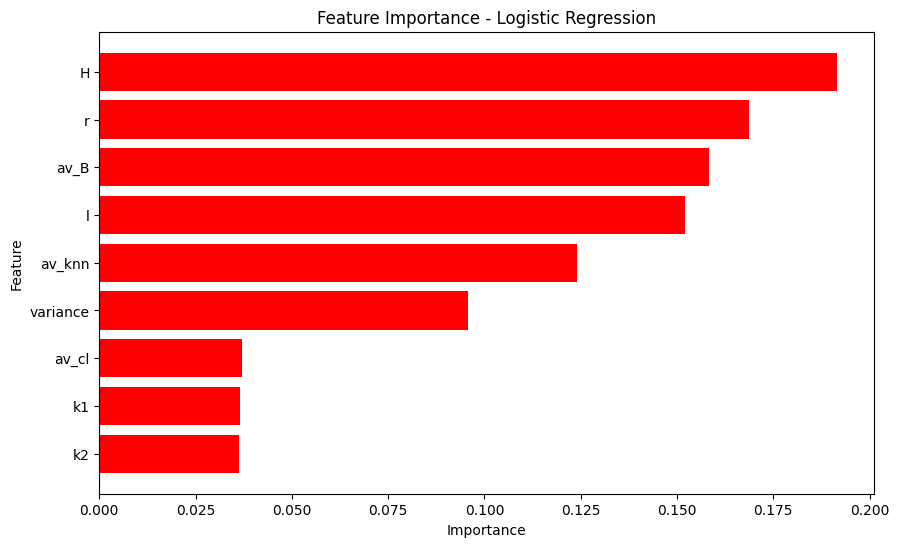

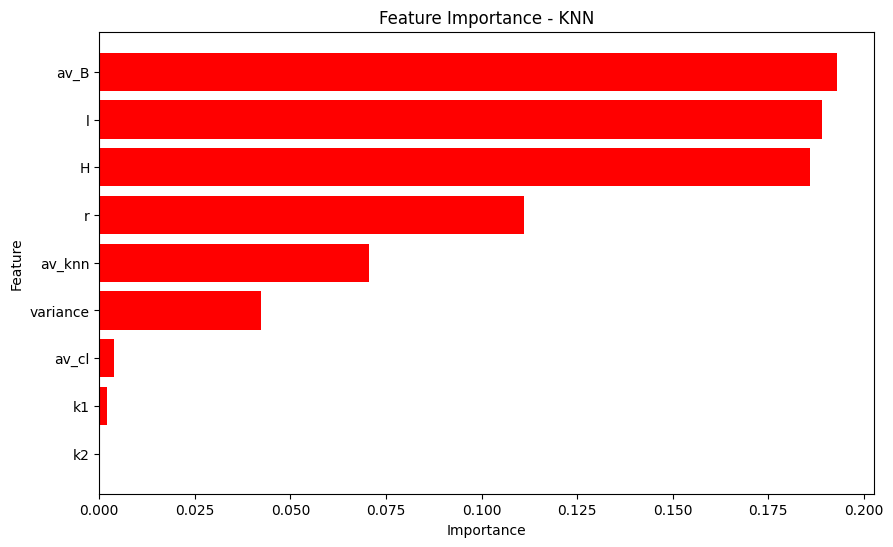

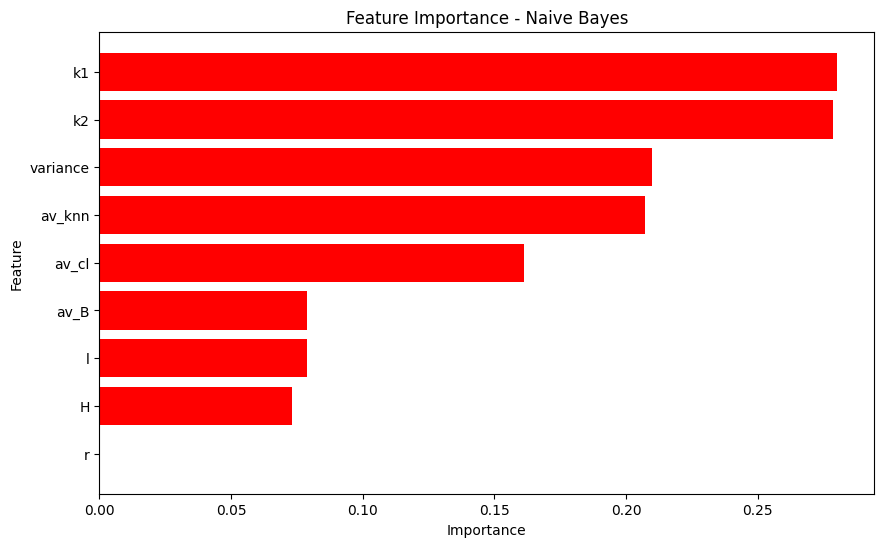

Pred KNN: BA
Pred LR: BA
Pred NB: WG


In [22]:
cl = ["ER", "WS", "BA", "WS__", "WG"]

# Suponha que X, y, e X_net sejam definidos anteriormente no código
pred1, pred2, pred3 = predicao_modelos_importance(X, y, X_net, cl )

print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)


O diagnóstico sobre as principais features que contribuem para a classificação da rede como BA será apresentado no final do notebook.

# Rede `foodweb_little_rock`

Número de nós: 183
Número de arestas: 2434


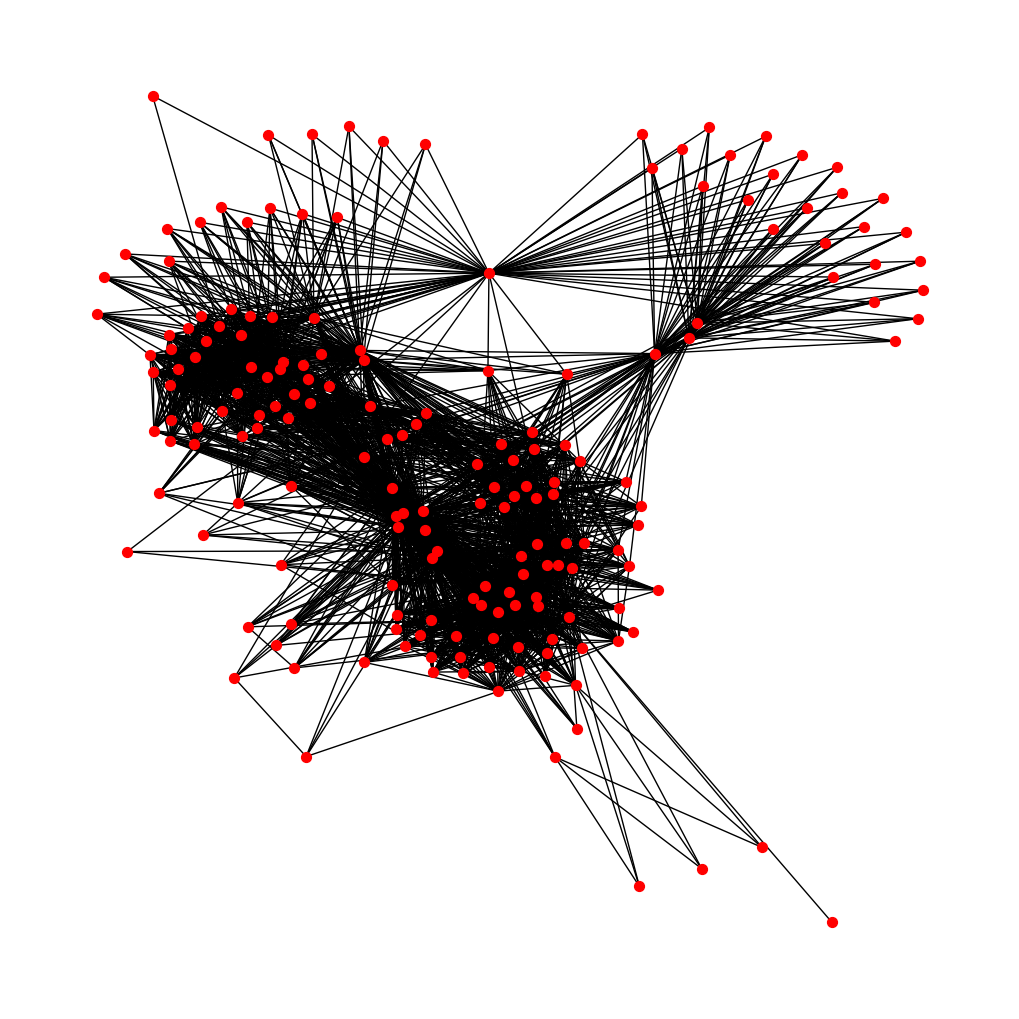

In [23]:

# Importando a rede do Graph-tool

G_gt = gt.collection.ns["foodweb_little_rock"]

# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="red", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau


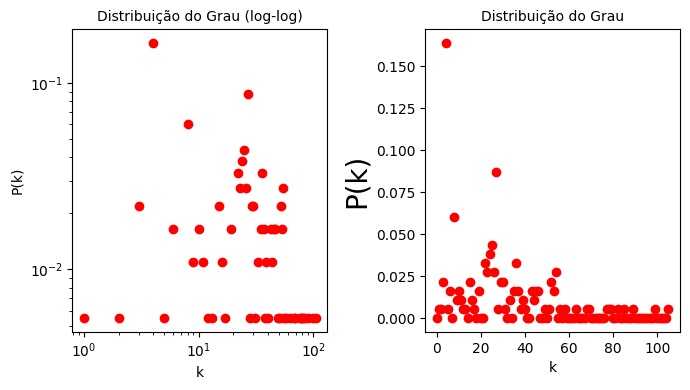

In [24]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "ro")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [25]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[26.601092896174862, 1140.9071038251366, 433.2889605542118, 0.32262801253502993, 2.1466402450009006, -0.2663851667433919, 5.037260444409152, 0.006335028977905529, 47.377969654887096]


### Aplicando a função de modelos de redes

In [26]:
# Parâmetros
N = len(G_nx)   # Número de nós
n_nets = 100    # Número de redes
av_degree = k1  # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [27]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [28]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: BA
Pred LR: BA
Pred NB: ER


Aqui, novamente temos dois modelos classificando a rede como BA (Barabási-Albert), então vamos avaliar as features que mais influenciaram nesta classificação.

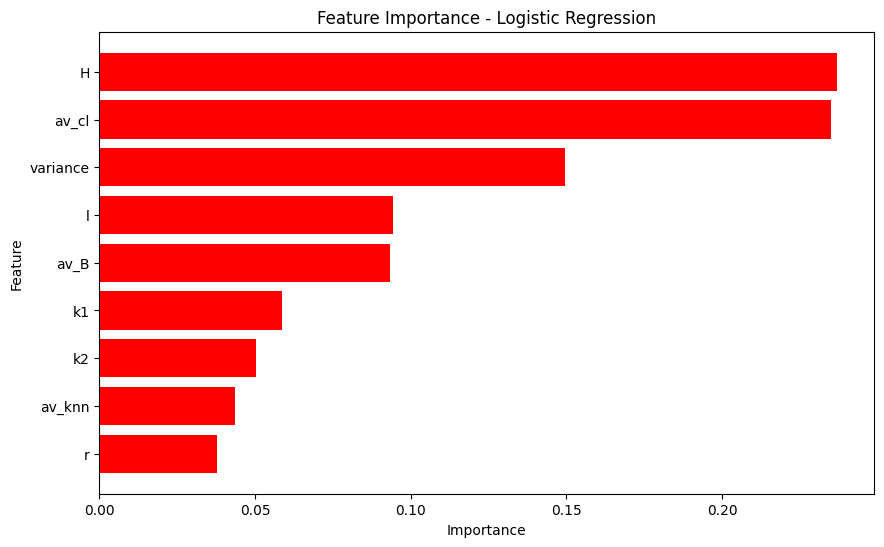

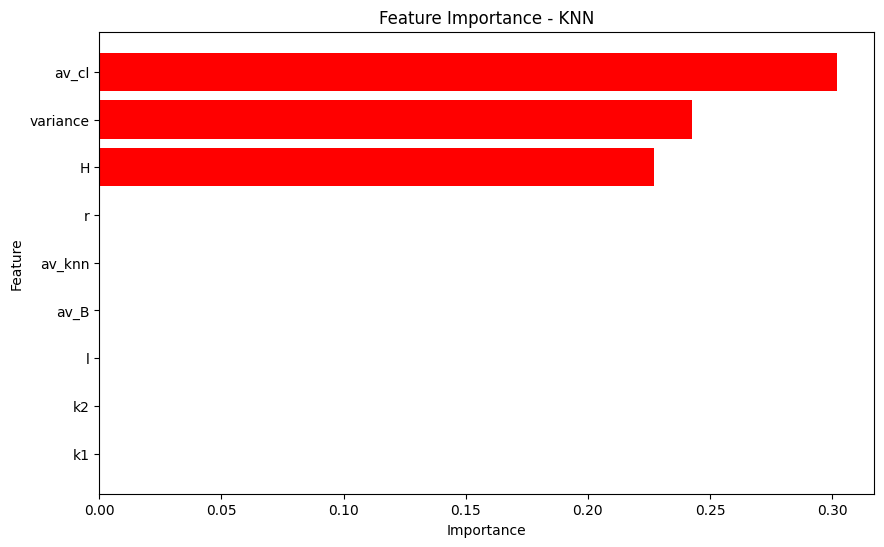

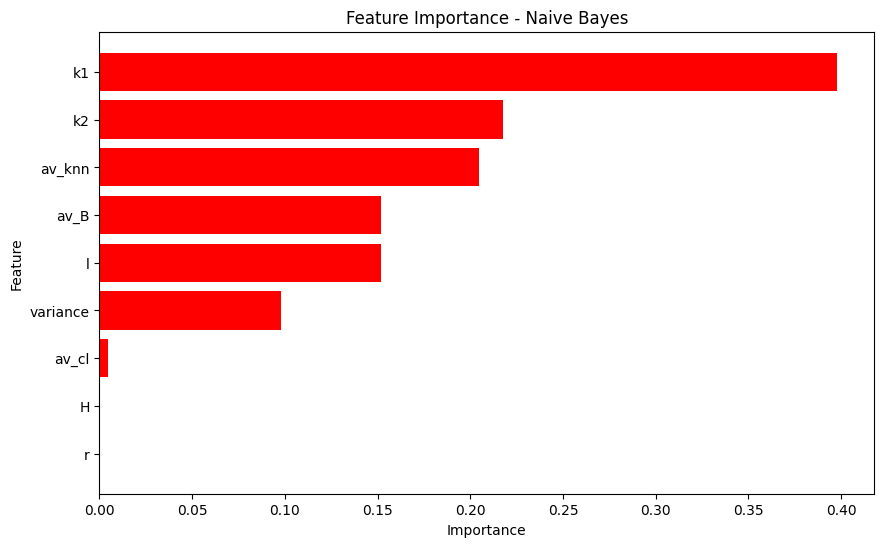

Pred KNN: BA
Pred LR: BA
Pred NB: ER


In [29]:
pred1, pred2, pred3 = predicao_modelos_importance(X, y, X_net, cl )

print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)


------

# Redes Tecnológicas

Agora vamos fazer a classificação para as redes sociais a seguir:

Site utilizado: https://networks.skewed.de

https://networks.skewed.de/net/cs_department (Aarhus Computer Science department relationships)

https://networks.skewed.de/net/facebook_friends (Maier Facebook friends (2014))

https://networks.skewed.de/net/macaques (Japanese macaques (1976))

# Rede `Aarhus Computer Science department relationships `

Número de nós: 61
Número de arestas: 353


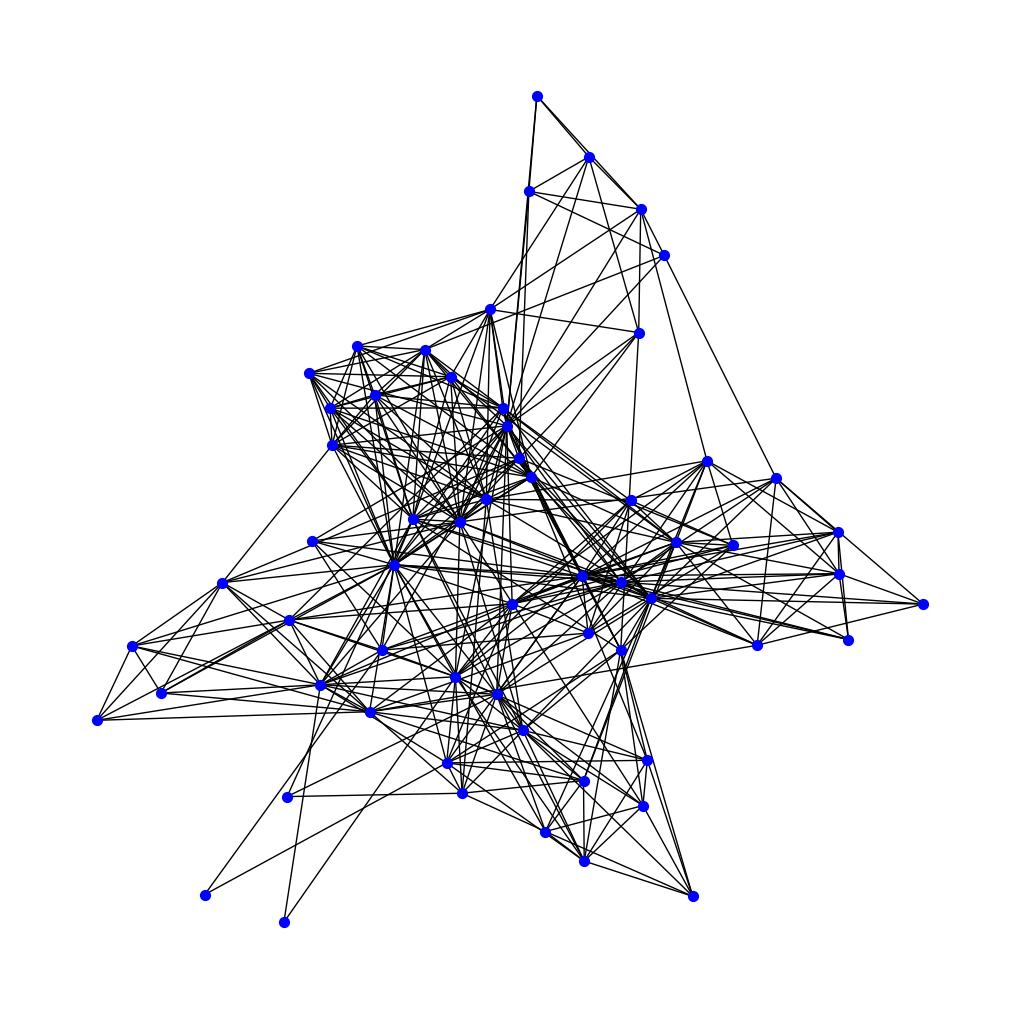

In [30]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["cs_department"]


# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="blue", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

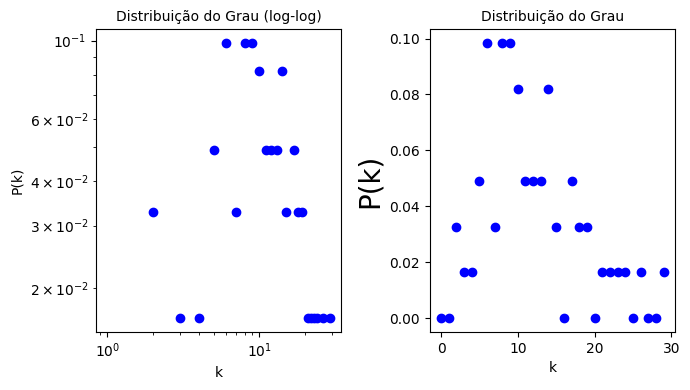

In [31]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "bo")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "bo")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [32]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[11.573770491803279, 168.98360655737704, 35.031443160440745, 0.5916203249211789, 2.0628415300546448, 0.053555254989922876, 4.233638264240398, 0.01801426322126517, 14.355564035150774]


### Aplicando a função de modelos de redes

In [33]:
# Parâmetros
N = len(G_nx)  # Número de nós
n_nets = 100    # Número de redes
av_degree = k1 # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)


### Aplicando a função para calcular a acurácia das redes geradas

In [34]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [35]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: BA
Pred LR: BA
Pred NB: ER


Vamos refazer a função das importâncias das features para alterarmos as cores de plotagem gráficas. Dois modelos também classificaram a rede como BA.

### Função para encontrar a importância das features

In [36]:
def predicao_modelos_importance(X, y, x_rede, cl):
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    x_rede = np.array(x_rede)
    x_rede = x_rede.reshape(1, len(x_rede))
    x_rede = scaler.transform(x_rede)

    feat = ["k1", "k2", "variance", "av_cl", "l", "r", "H", "av_B", "av_knn"]

    k = 5
    model1 = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    model1.fit(X, y)
    y_pred1 = model1.predict(x_rede)
    pred1 = cl[int(y_pred1.item())]

    model2 = LogisticRegression(solver="lbfgs", max_iter=1000)
    model2.fit(X, y)
    y_pred2 = model2.predict(x_rede)
    pred2 = cl[int(y_pred2.item())]

    model3 = GaussianNB()
    model3.fit(X, y)
    y_pred3 = model3.predict(x_rede)
    pred3 = cl[int(y_pred3.item())]

    # Importância das features para Regressão Logística
    coefficients = model2.coef_
    avg_importance = np.mean(np.abs(coefficients), axis=0)
    normalized_importance = avg_importance / np.sum(avg_importance)
    feature_importance_lr = pd.DataFrame({"Feature": feat, "Importance": normalized_importance})
    feature_importance_lr = feature_importance_lr.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'], color='blue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - Logistic Regression")
    plt.show()

    # Importância das features para KNN
    result_knn = permutation_importance(model1, X, y, n_repeats=30, random_state=42)
    feature_importance_knn = pd.DataFrame({"Feature": feat, "Importance": result_knn.importances_mean})
    feature_importance_knn = feature_importance_knn.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_knn['Feature'], feature_importance_knn['Importance'], color='blue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - KNN")
    plt.show()

    # Importância das features para GaussianNB
    result_nb = permutation_importance(model3, X, y, n_repeats=30, random_state=42)
    feature_importance_nb = pd.DataFrame({"Feature": feat, "Importance": result_nb.importances_mean})
    feature_importance_nb = feature_importance_nb.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_nb['Feature'], feature_importance_nb['Importance'], color='blue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - Naive Bayes")
    plt.show()

    return pred1, pred2, pred3

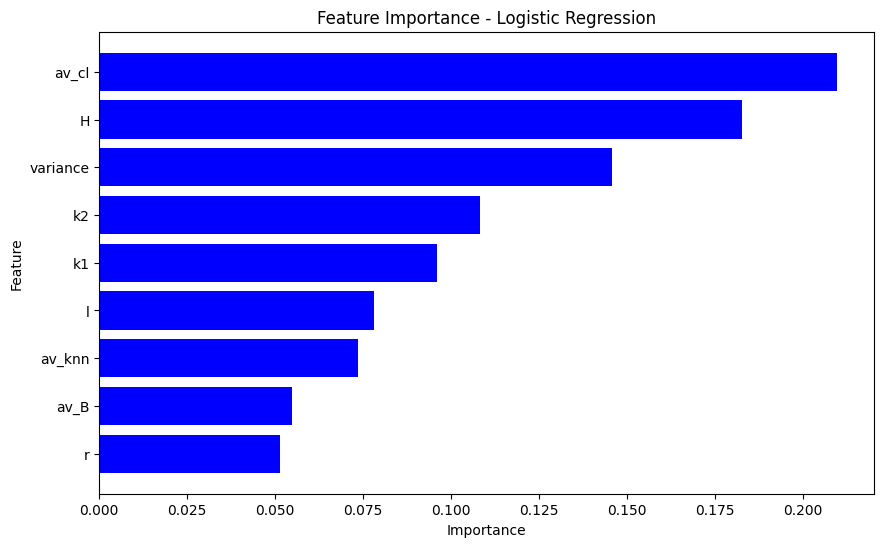

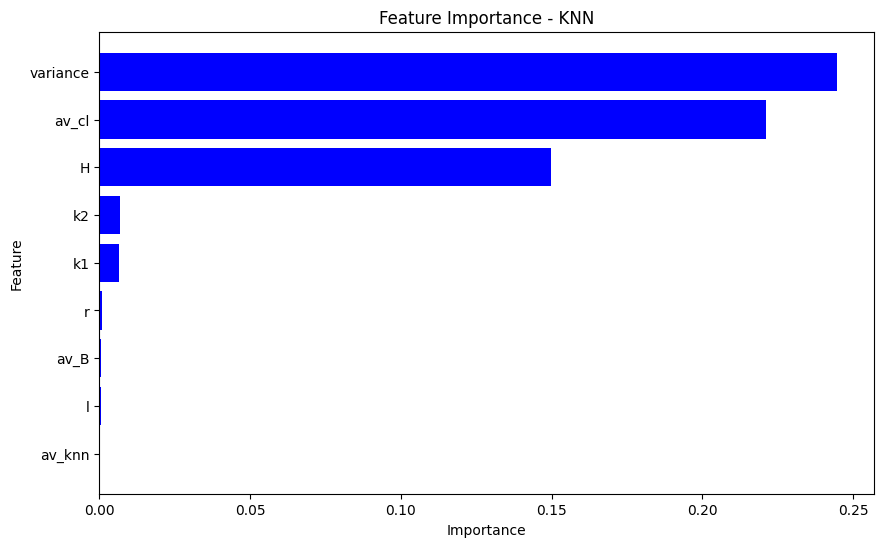

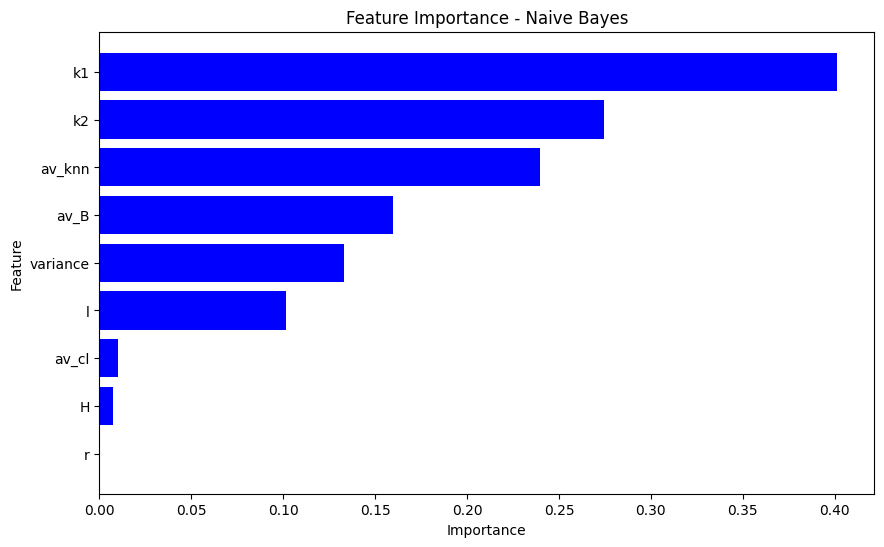

Pred KNN: BA
Pred LR: BA
Pred NB: ER


In [37]:
pred1, pred2, pred3 = predicao_modelos_importance(X, y, X_net, cl )

print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

# Rede `Maier Facebook friends (2014)`

Número de nós: 329
Número de arestas: 1954


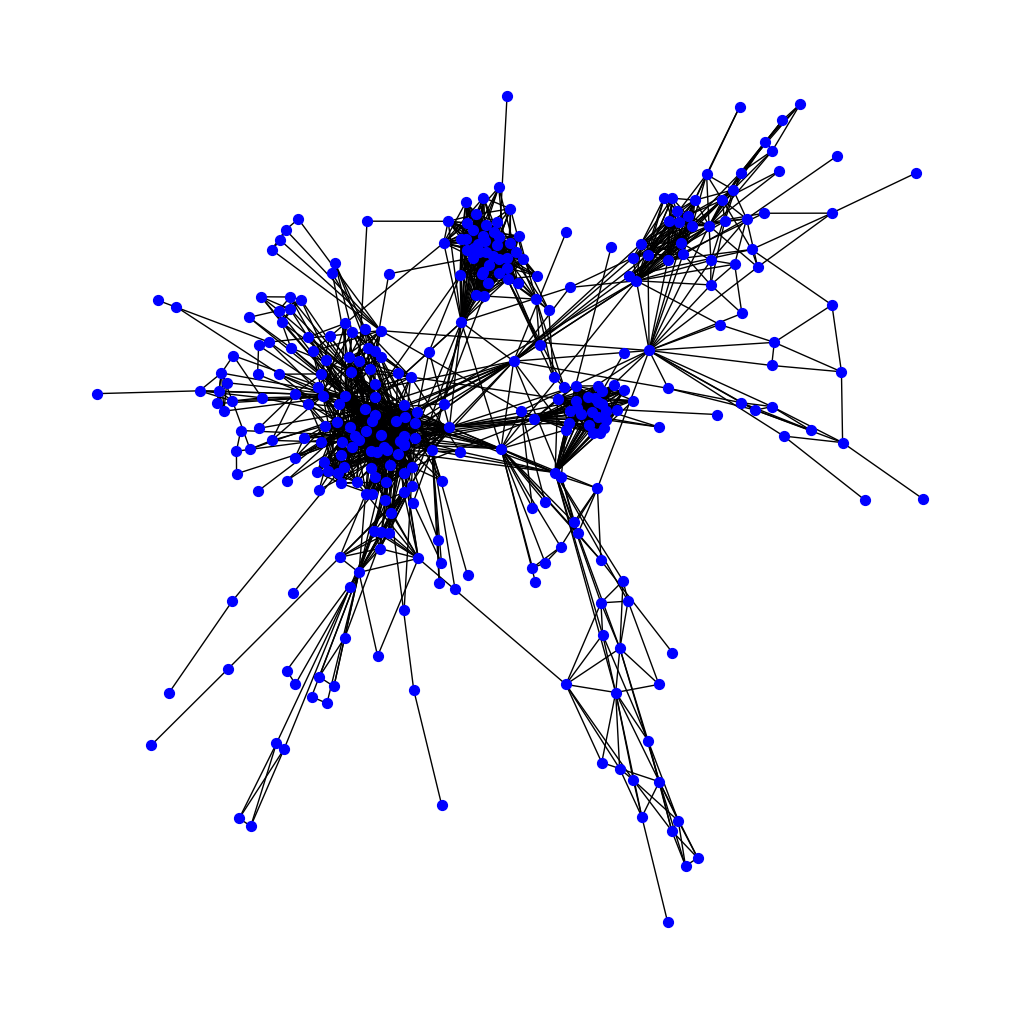

In [38]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["facebook_friends"]


# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="blue", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

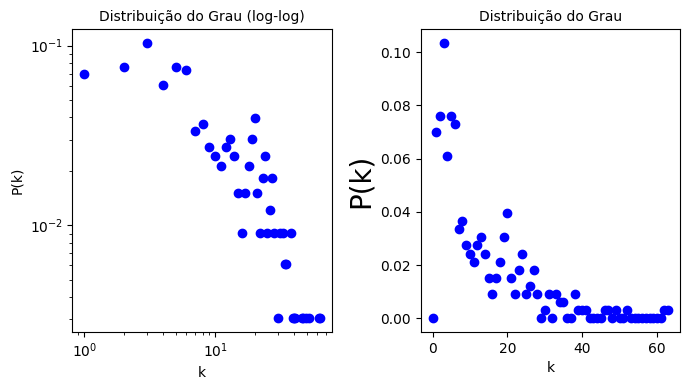

In [39]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "bo")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "bo")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [40]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[11.878419452887538, 260.8632218844985, 119.76637318576141, 0.6052943472285397, 3.584216769219364, 0.07388134601973691, 4.772892065757319, 0.007902803575594386, 19.605534801180106]


### Aplicando a função de modelos de redes

In [41]:
# Parâmetros
N = len(G_nx)  # Número de nós
n_nets = 100    # Número de redes
av_degree = k1 # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [42]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [43]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: BA
Pred LR: BA
Pred NB: WG


### Plotagem da importância das features

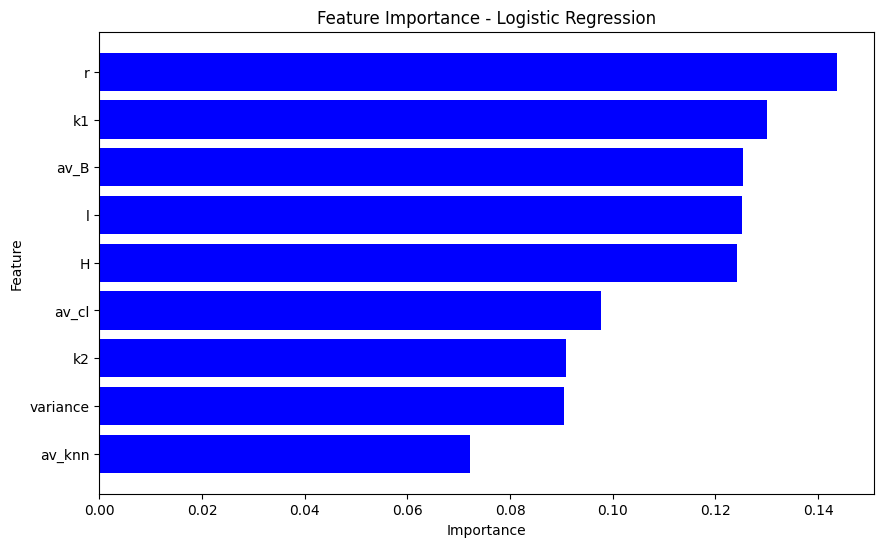

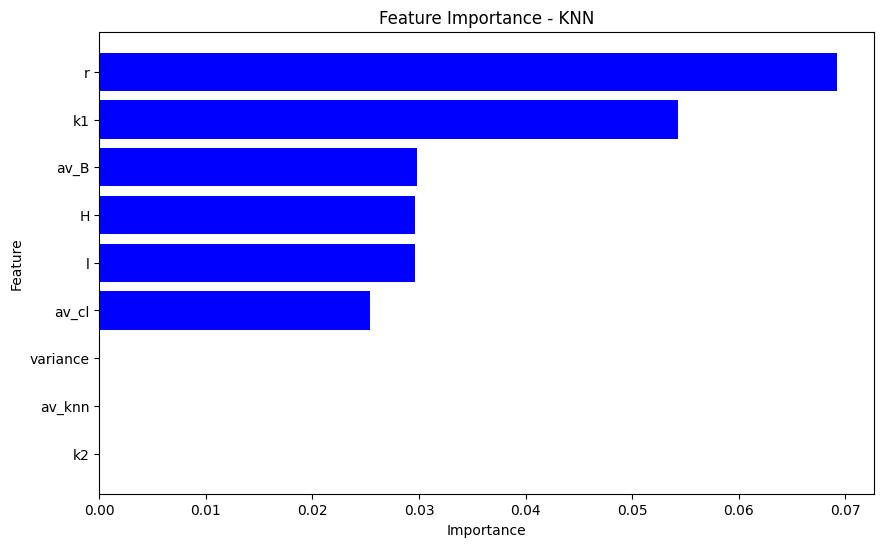

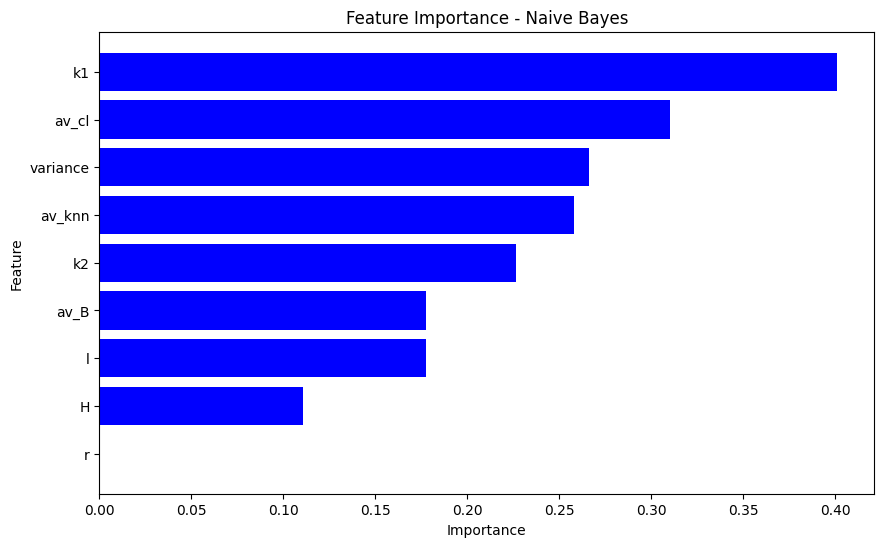

Pred KNN: BA
Pred LR: BA
Pred NB: WG


In [44]:
pred1, pred2, pred3 = predicao_modelos_importance(X, y, X_net, cl )

print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

# Rede `Japanese macaques (1976)`

Número de nós: 62
Número de arestas: 1167


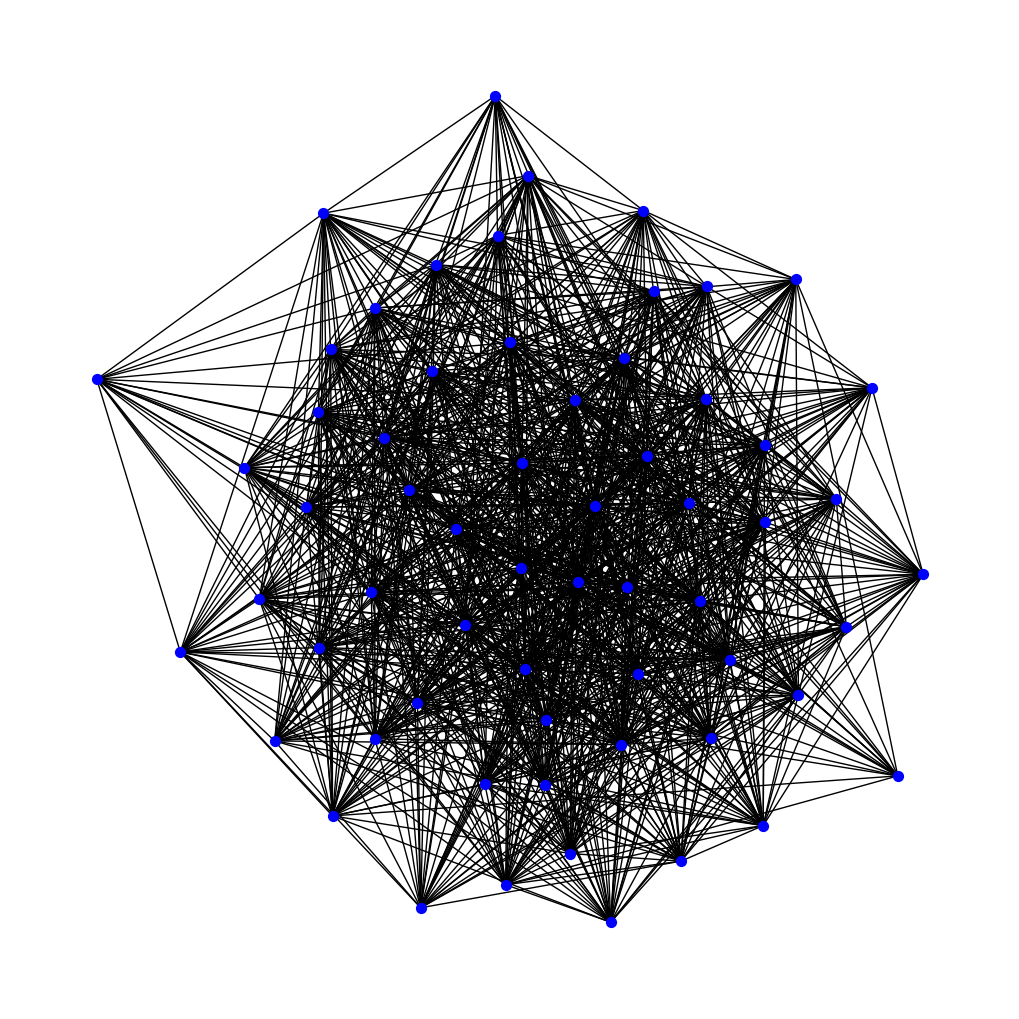

In [45]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["macaques"]


# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="blue", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

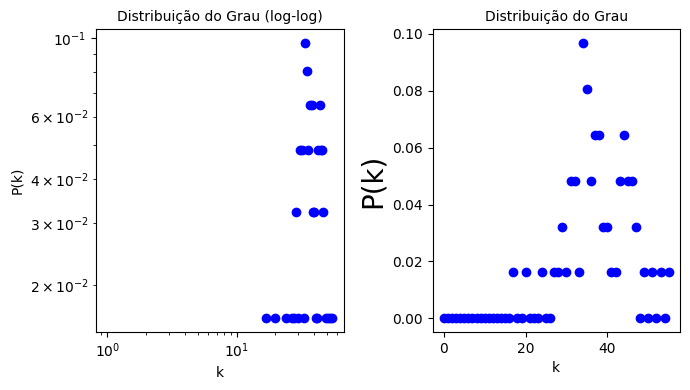

In [46]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "bo")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "bo")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

###  Aplicando a função de features

In [47]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[37.645161290322584, 1471.9354838709678, 54.7773152965658, 0.6671447959822828, 1.3828662083553676, -0.07257998232134918, 4.540506947616801, 0.006381103472589458, 39.20825132392975]


### Aplicando a função modelo de redes

In [48]:
# Parâmetros
N = len(G_nx)  # Número de nós
n_nets = 100   # Número de redes
av_degree = k1 # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [49]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 0.98
Accuracy LR: 0.9866666666666667
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [50]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: ER
Pred LR: ER
Pred NB: ER


-----
# Redes Tecnológicas

Agora vamos fazer a classificação para as redes tecnológicas a seguir:

Site utilizado: https://networks.skewed.de

https://networks.skewed.de/net/internet_top_pop (Internet topology (PoP level) (1969-2012))

https://networks.skewed.de/net/software_dependencies (Software dependencies (2010))

https://networks.skewed.de/net/route_views (Route Views AS graphs (1997-1998))

# Rede `Internet topology`

Número de nós: 83
Número de arestas: 99


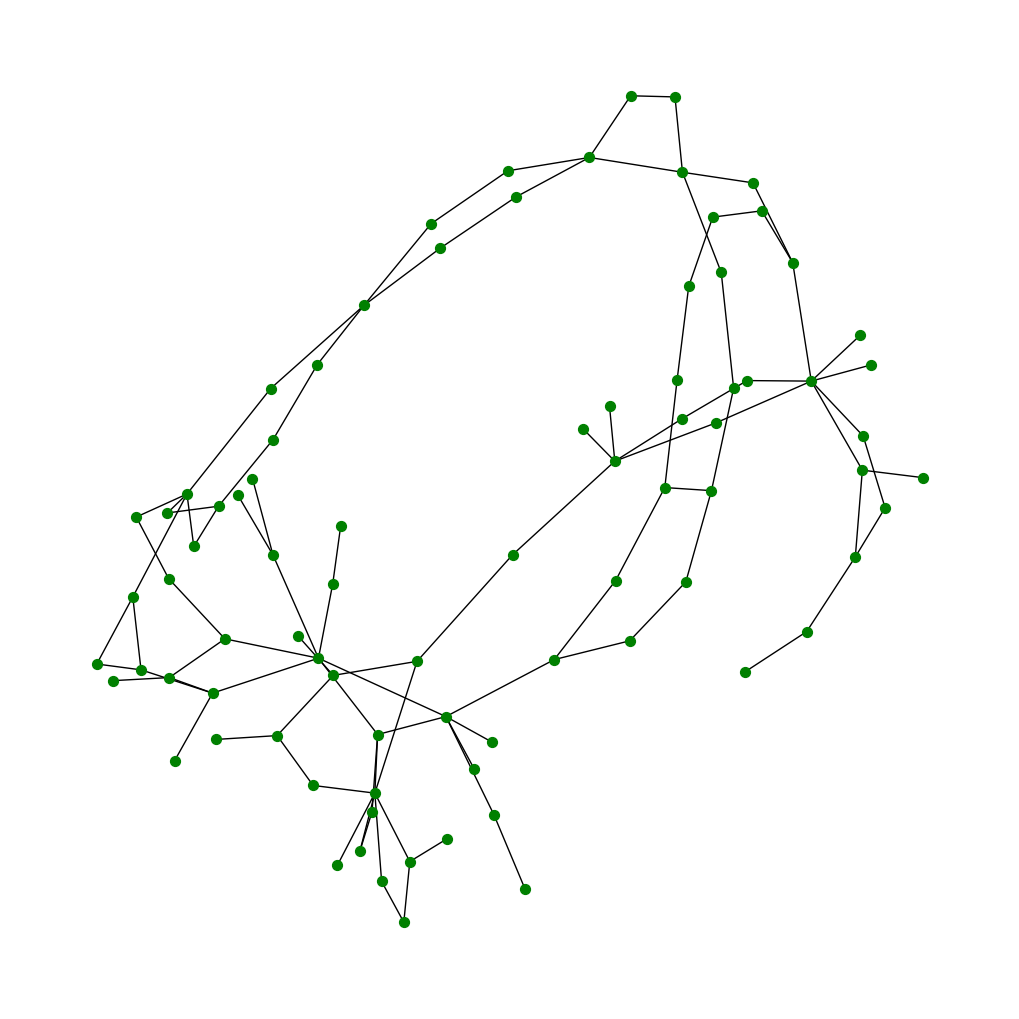

In [51]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["internet_top_pop/Oteglobe"]


# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="green", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

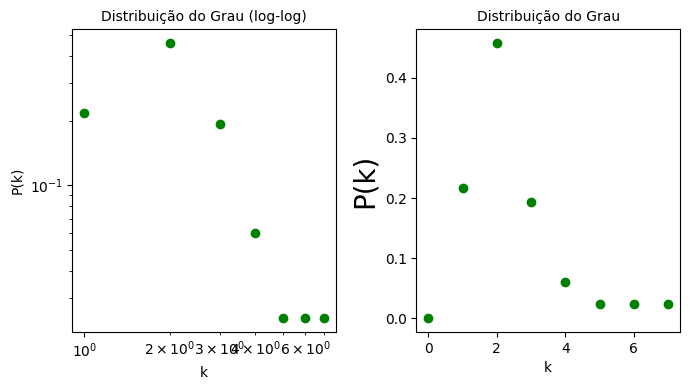

In [52]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "go")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "go")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [53]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[2.3855421686746987, 7.397590361445783, 1.7067789229205985, 0.023694779116465864, 6.523655598001763, -0.21937664288396574, 2.08480405771735, 0.0681932789876761, 3.3180149168100974]


### Aplicando a função de modelos de redes

In [54]:
# Parâmetros
N = len(G_nx)  # Número de nós
n_nets = 100   # Número de redes
av_degree = k1 # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [55]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 0.9
Accuracy LR: 0.9066666666666666
Accuracy NB: 0.8933333333333333


### Aplicando a função de classificação de rede

In [56]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: ER
Pred LR: ER
Pred NB: WG


# Rede `software_dependencies`

Número de nós: 228
Número de arestas: 491


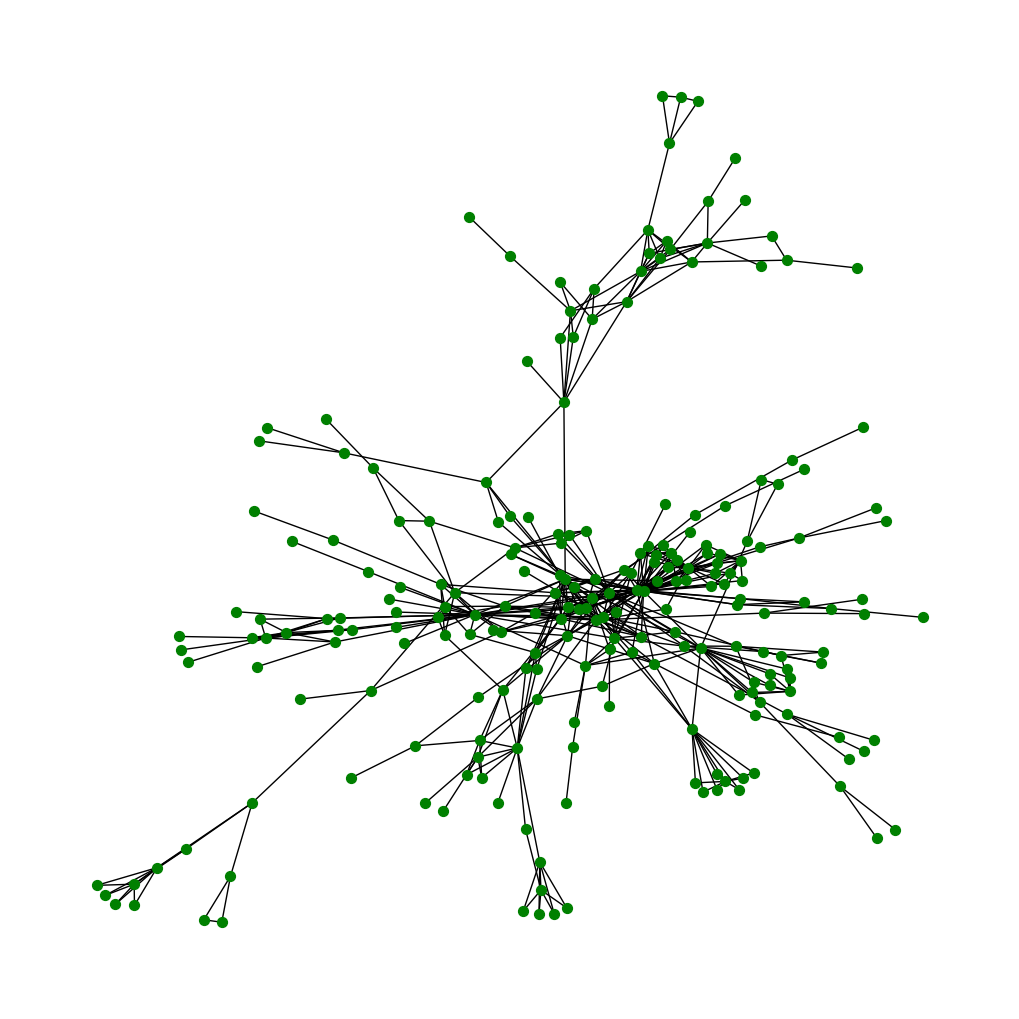

In [57]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["software_dependencies/flamingo"]


# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="green", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

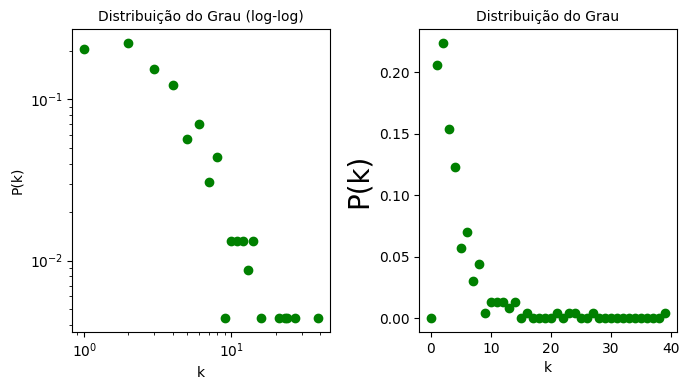

In [58]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "go")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "go")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [59]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[4.307017543859649, 39.70175438596491, 21.15135426285011, 0.3071431272272333, 4.679225597032228, -0.05727834402003629, 3.2254942087794505, 0.01627975927890367, 9.214051025287677]


### Aplicando a função de modelos de redes

In [60]:
# Parâmetros
N = len(G_nx)  # Número de nós
n_nets = 100   # Número de redes
av_degree = k1 # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [61]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [62]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: BA
Pred LR: BA
Pred NB: WG


Para a rede tecnológica `software_dependencies`, os modelos a classificaram como BA (Barabási-Albert). Vamos, portanto, analisar as variáveis que mais contribuem para essa classificação.

Vale destacar que iremos redefinir a função que plota as importâncias das features, garantindo que as cores utilizadas estejam alinhadas com as cores que estamos considerando para as redes tecnológicas.

### Função para encontrar a importância das features

In [63]:
def predicao_modelos_importance(X, y, x_rede, cl):
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    x_rede = np.array(x_rede)
    x_rede = x_rede.reshape(1, len(x_rede))
    x_rede = scaler.transform(x_rede)

    feat = ["k1", "k2", "variance", "av_cl", "l", "r", "H", "av_B", "av_knn"]

    k = 5
    model1 = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    model1.fit(X, y)
    y_pred1 = model1.predict(x_rede)
    pred1 = cl[int(y_pred1.item())]

    model2 = LogisticRegression(solver="lbfgs", max_iter=1000)
    model2.fit(X, y)
    y_pred2 = model2.predict(x_rede)
    pred2 = cl[int(y_pred2.item())]

    model3 = GaussianNB()
    model3.fit(X, y)
    y_pred3 = model3.predict(x_rede)
    pred3 = cl[int(y_pred3.item())]

    # Importância das features para Regressão Logística
    coefficients = model2.coef_
    avg_importance = np.mean(np.abs(coefficients), axis=0)
    normalized_importance = avg_importance / np.sum(avg_importance)
    feature_importance_lr = pd.DataFrame({"Feature": feat, "Importance": normalized_importance})
    feature_importance_lr = feature_importance_lr.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'], color='green')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - Logistic Regression")
    plt.show()

    # Importância das features para KNN
    result_knn = permutation_importance(model1, X, y, n_repeats=30, random_state=42)
    feature_importance_knn = pd.DataFrame({"Feature": feat, "Importance": result_knn.importances_mean})
    feature_importance_knn = feature_importance_knn.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_knn['Feature'], feature_importance_knn['Importance'], color='green')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - KNN")
    plt.show()

    # Importância das features para GaussianNB
    result_nb = permutation_importance(model3, X, y, n_repeats=30, random_state=42)
    feature_importance_nb = pd.DataFrame({"Feature": feat, "Importance": result_nb.importances_mean})
    feature_importance_nb = feature_importance_nb.sort_values("Importance", ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_nb['Feature'], feature_importance_nb['Importance'], color='green')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title("Feature Importance - Naive Bayes")
    plt.show()

    return pred1, pred2, pred3

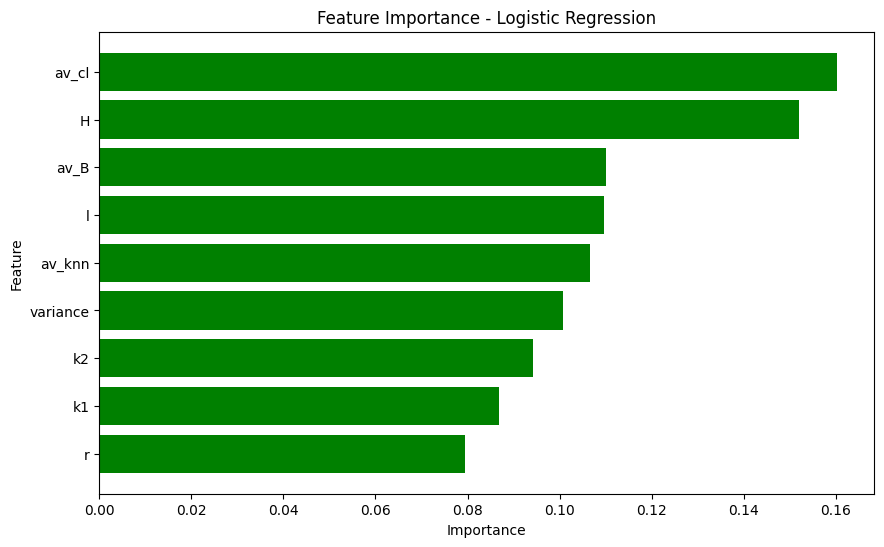

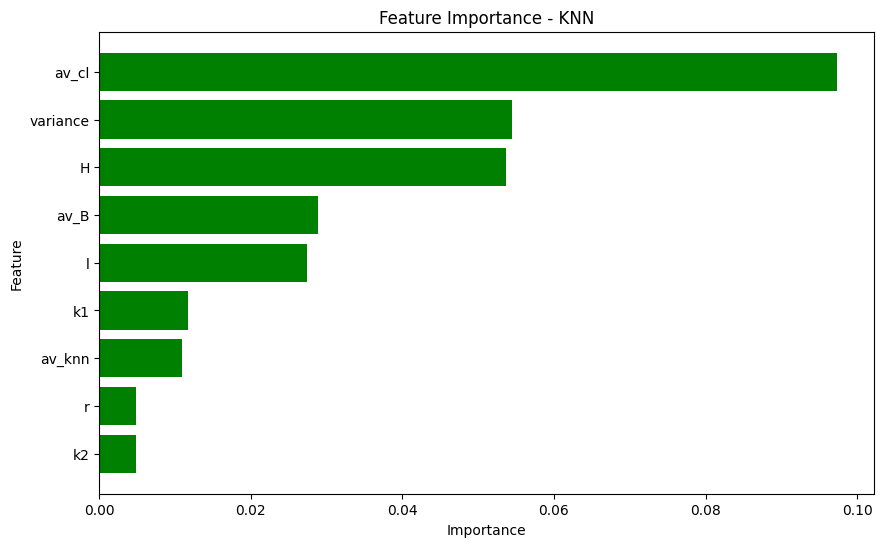

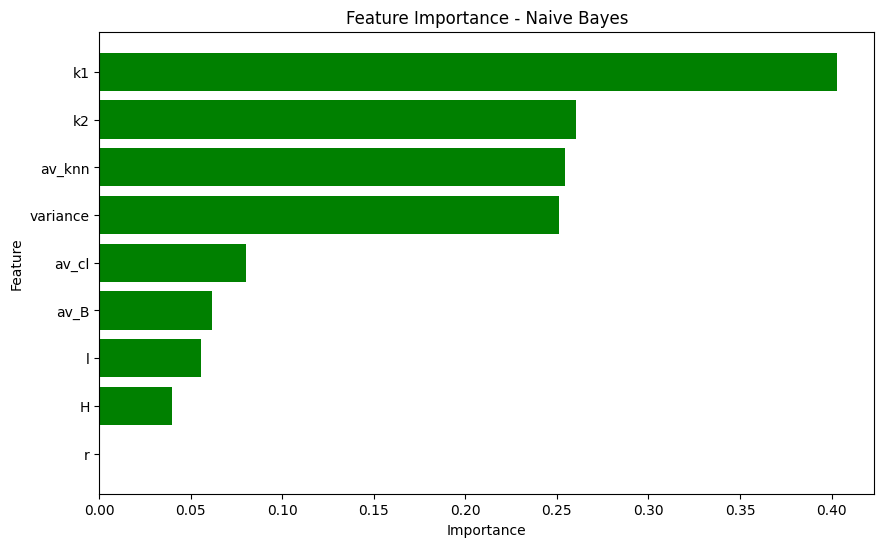

Pred KNN: BA
Pred LR: BA
Pred NB: WG


In [64]:
pred1, pred2, pred3 = predicao_modelos_importance(X, y, X_net, cl )

print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

# Rede `Route Views AS graphs`

Número de nós: 561
Número de arestas: 1280


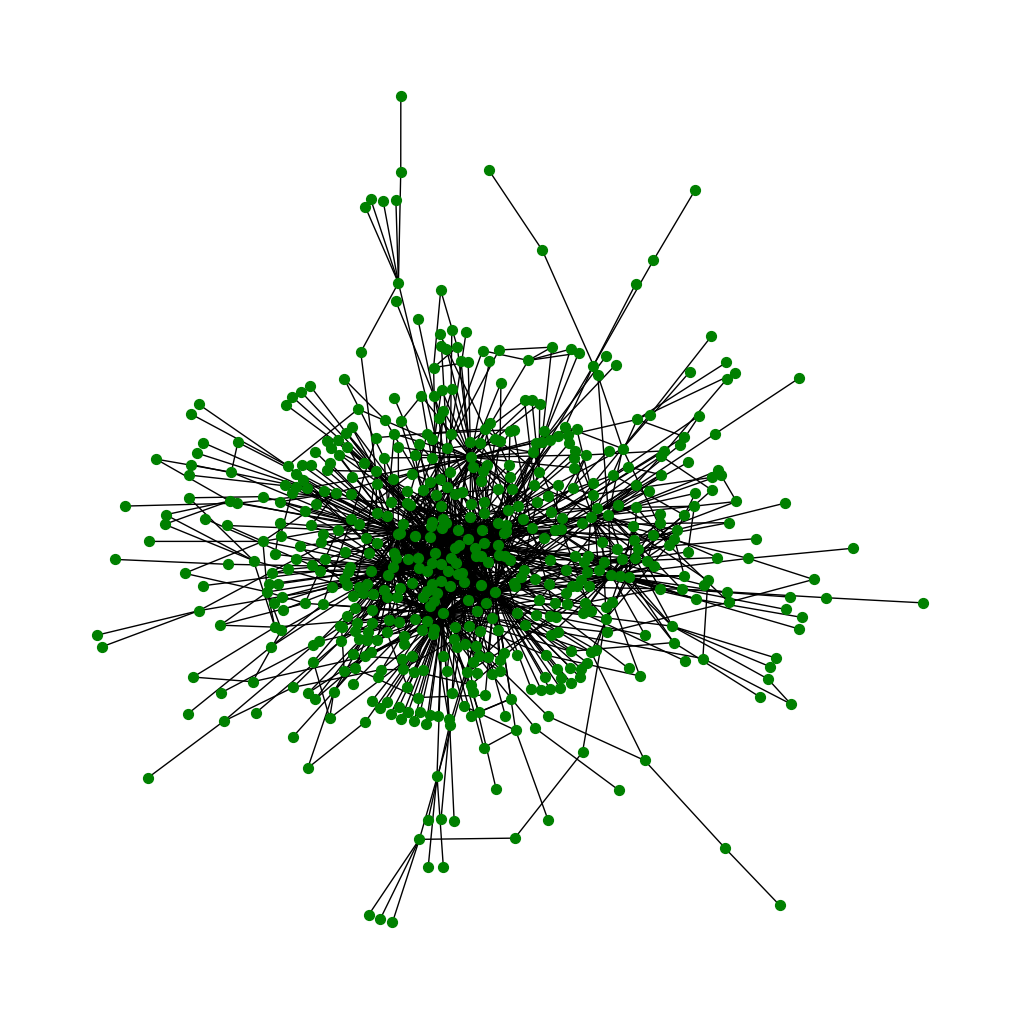

In [65]:
# Importando a rede do Graph-tool

G_gt = gt.collection.ns["route_views/19990110"]


# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(10, 10))
nx.draw(G_nx, pos, node_color="green", node_size=50, with_labels=False)
plt.show()

### Distribuição do grau

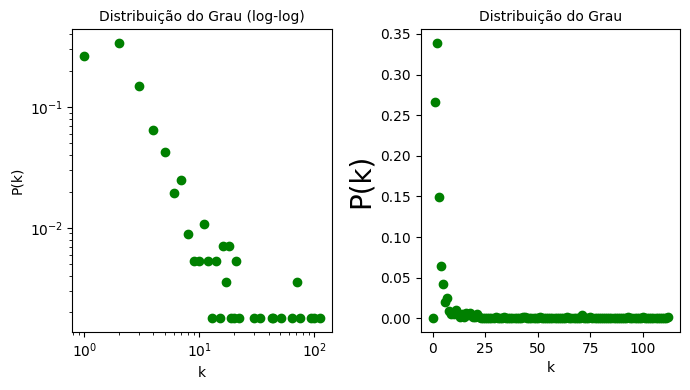

In [66]:
ks, Pk = degree_distribution(G_nx)

plt.figure(figsize=(7, 4))

# Primeiro gráfico (log-log)
plt.subplot(1, 2, 1)
plt.xscale("log")
plt.yscale("log")
plt.plot(ks, Pk, "go")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=10)
plt.title("Distribuição do Grau (log-log)", fontsize=10)

# Segundo gráfico (linear)
plt.subplot(1, 2, 2)
plt.plot(ks, Pk, "go")
plt.xlabel("k", fontsize=10)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição do Grau", fontsize=10)

plt.tight_layout()
plt.show()

### Aplicando a função de features

In [67]:
k1, k2, variance, av_cl, l, r, H, av_B, av_knn = measures(G_nx)
X_net = [k1, k2, variance, av_cl, l, r, H, av_B, av_knn]
print(X_net)

[4.563279857397505, 128.0392156862745, 107.21569262934472, 0.1694544663368795, 3.4043353705118413, -0.2513049200646509, 2.876437516013806, 0.0043011366198780696, 34.548880140916694]


### Aplicando a função de modelos de redes

In [68]:
# Parâmetros
N = len(G_nx)  # Número de nós
n_nets = 100   # Número de redes
av_degree = k1 # Grau médio
X = None
y = None
# Geração dos dados
X, y, cl = generate_network_data(N, av_degree, n_nets)

### Aplicando a função para calcular a acurácia das redes geradas

In [69]:
score1, score2, score3 = accuracy_models(X, y)
print("Accuracy KNN:", score1)
print("Accuracy LR:", score2)
print("Accuracy NB:", score3)

Accuracy KNN: 1.0
Accuracy LR: 1.0
Accuracy NB: 1.0


### Aplicando a função de classificação de rede

In [70]:
pred1, pred2, pred3 = predicao_modelos(X, y, X_net)
print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

X_rede: (1, 9)
Pred KNN: BA
Pred LR: BA
Pred NB: WG


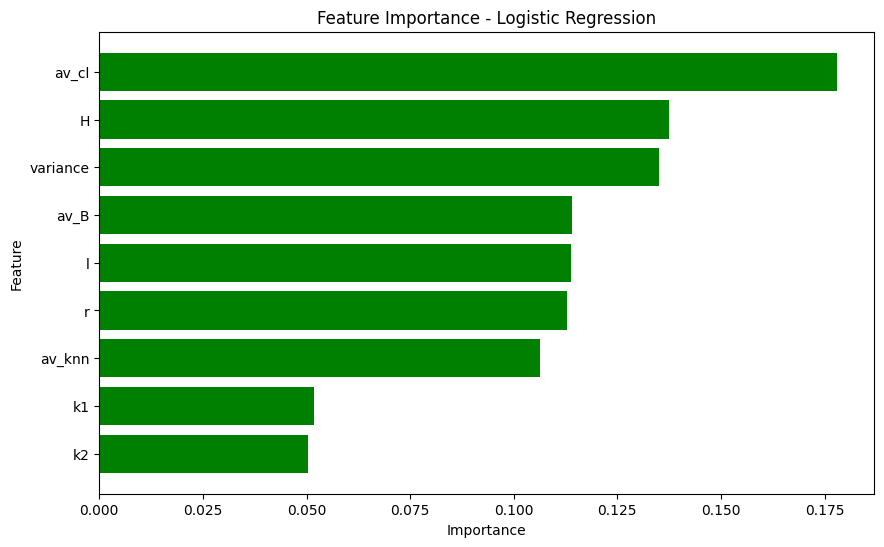

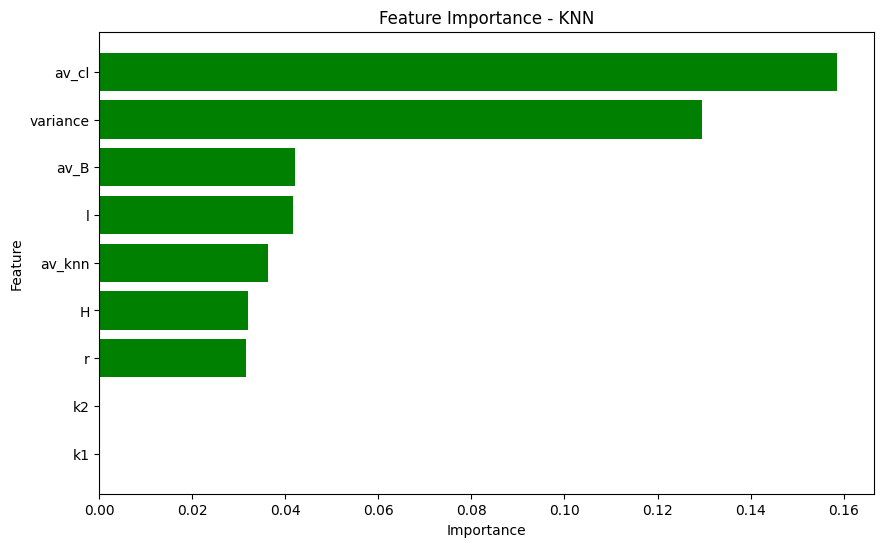

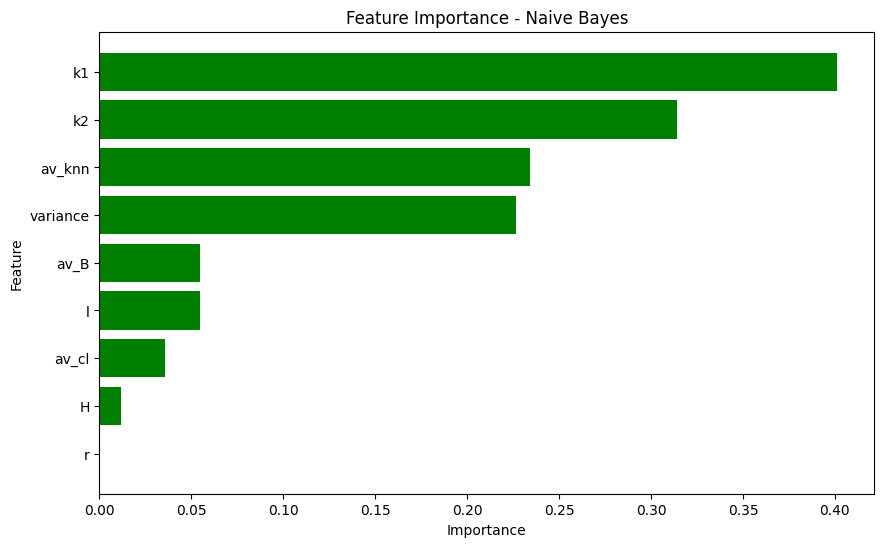

Pred KNN: BA
Pred LR: BA
Pred NB: WG


In [71]:
pred1, pred2, pred3 = predicao_modelos_importance(X, y, X_net, cl )

print("Pred KNN:", pred1)
print("Pred LR:", pred2)
print("Pred NB:", pred3)

# Hipótese:
----
Redes do mesmo tipo seguem o mesmo modelo. Verifique se essa hipótese é verdadeira.

----

Consideramos o modelo final de uma rede como sendo o modelo com maior frequência entre as classificações dos modelos KNN, Regressão Logística e Naive Bayes.


A hipótese, de forma geral, é falsa. Selecionamos três redes em cada uma das categorias: "Redes Biológicas", "Redes Sociais" e "Redes Tecnológicas". Em todas as categorias, pelo menos uma rede foi classificada por um modelo diferente dos demais. Além disso, vale ressaltar que todos os modelos de classificação foram treinados sob as mesmas condições de otimização de hiperparâmetros.

**MODELOS DE CLASSIFICAÇÃO UTILIZADOS**

- **KNN** - K-Nearest Neighbors
- **LR**  - Linear Regression
- **NB**  - Naive Bayes

| **Categoria**        | **Redes**                                     | **KNN** | **LR** | **NB** | **Modelo Final** |
|----------------------|-----------------------------------------------|---------|--------|--------|------------------|
| **Redes Biológicas** | celegans_2019/hermaphrodite_gap_junction      | WS      | WS     | ER     | WS               |
|                      | yeast_transcription                           | BA      | BA     | WG     | BA               |
|                      | foodweb_little_rock                           | BA      | BA     | ER     | BA               |
| **Redes Sociais**    | Aarhus Computer Science                       | BA      | BA     | ER     | BA               |
|                      | Maier Facebook friends                        | BA      | BA     | WG     | BA               |
|                      | Japanese macaques                             | ER      | ER     | ER     | ER               |
| **Redes Tecnológicas** | Internet topology                           | ER      | ER     | WG     | ER               |
|                      | Software dependencies                         | BA      | BA     | WG     | BA               |
|                      | Route Views AS graphs                         | BA      | BA     | WG     | BA               |



---

**Bônus (não é obrigatório):** Identifique as principais diferenças entre os modelos. Isto é, quais medidas mais contribuem para que uma rede seja classificada como sendo do
modelo BA

---

Vamos considerar apenas as redes classificadas como BA (Barabási-Albert), para analisar quais features mais impactaram essa classificação.

- Redes Biológicas:
1. `yeast_transcription`;
2. `foodweb_little_rock`.

- Redes Sociais:
1. `Aarhus Computer Science`;
2. `Maier Facebook friends`.

- Redes Tecnológicas:
1. `Software dependencies`;
2. `Route Views AS graphs`.


---

- **k1:** Primeiro momento do grau;
- **k2:** Segundo momento do grau;
- **variance:** Variância;
- **av_cl:**  Average Clustering;
- **l:** Average shortest path length;
- **r:** Grau do coeficiente de assortatividade;
- **H:** Entropia de Shannon;
- **av_B:**
- **av_knn:**

### Redes Biológicas

Vamos avaliar as cinco principais features que mais impactaram na classificação da rede `yeast_transcription` como sendo uma rede de BA.

| **Modelo** | **Feature 1**  | **Feature 2**  | **Feature 3**  | **Feature 4**  | **Feature 5**  | **Classificação** |
|------------|----------------|----------------|----------------|----------------|----------------|-------------------|
| **KNN**    | av_B     | I     | H     | r     |   av_knn   | BA                |
| **LR**     | H     | r     | av_B     | I     | av_knn     | BA                |
| **NB**     | k1     | k2     | variance     | av_knn     | av_cl     | WG               |

Note que, as features que mais contribuem para a rede seja classificada como BA são: av_B, I, H, r e av_knn e estas estão presentes nos dois modelos que classificaram a rede como BA e são as cinco principais features. Por outro lado, o modelo **NB** teve como principais features k1, k2, variance, av_knn e av_cl das quais apenas uma teve alta importância na classificação dos modelos **KNN** e **LR**.

Analogamente, para a rede `foodweb_little_rock`

| **Modelo** | **Feature 1**  | **Feature 2**  | **Feature 3**  | **Feature 4**  | **Feature 5**  | **Classificação** |
|------------|----------------|----------------|----------------|----------------|----------------|-------------------|
| **KNN**    | av_cl     | variance     | H     | -     | -     | BA                |
| **LR**     | H     | av_cl     | variance     | I     | av_B     | BA                |
| **NB**     | av_cl     | variance     | H     | r     | av_knn     | ER              |

O modelo **KNN** utilizou classificou apenas três  fetaures para classificar como BA a rede  `foodweb_little_rock` e essas mesmas features (adicionalmente I, av_B) também foram utilizadas pelo modelo de **LR** para classificar a rede como BA. Isto se deve essencialmente a topologia da rede e o algoritmo de classificação utilizado.

---

### Redes Sociais

Vamos avaliar as cinco principais features que mais impactaram na classificação da rede `Aarhus Computer Science` como sendo uma rede de BA.

| **Modelo** | **Feature 1**  | **Feature 2**  | **Feature 3**  | **Feature 4**  | **Feature 5**  | **Classificação** |
|------------|----------------|----------------|----------------|----------------|----------------|-------------------|
| **KNN**    | variance     | av_cl     | H     | k2     |   k1   | BA                |
| **LR**     | av_cl     | H     | variance     | k2     | k1     | BA                |
| **NB**     | k1     | k2     | av_knn     | av_B     | variance     | ER               |


Analogamente, para a rede `Maier Facebook friends`

| **Modelo** | **Feature 1**  | **Feature 2**  | **Feature 3**  | **Feature 4**  | **Feature 5**  | **Classificação** |
|------------|----------------|----------------|----------------|----------------|----------------|-------------------|
| **KNN**    | r     | k1     | av_B     | H     | I     | BA                |
| **LR**     | r    | k2     | av_B     | I     | H     | BA                |
| **NB**     | k1     | av_cl     | variance     | av_knn     | k2     | WG              |

---

### Redes Tecnológicas

Vamos avaliar as cinco principais features que mais impactaram na classificação da rede `Software dependencies` como sendo uma rede de BA.


| **Modelo** | **Feature 1**  | **Feature 2**  | **Feature 3**  | **Feature 4**  | **Feature 5**  | **Classificação** |
|------------|----------------|----------------|----------------|----------------|----------------|-------------------|
| **KNN**    | av_cl     | variance     | H     | av_B     |   I   | BA                |
| **LR**     | av_cl     | H     | av_B     | I     | av_knn     | BA                |
| **NB**     | k1     | k2     | av_knn     | variance     | av_cl     | WG              |

Analogamente, para a rede `Route Views AS graphs`

| **Modelo** | **Feature 1**  | **Feature 2**  | **Feature 3**  | **Feature 4**  | **Feature 5**  | **Classificação** |
|------------|----------------|----------------|----------------|----------------|----------------|-------------------|
| **KNN**    | av_cl     | variance     | av_B     | I     | av_knn    | BA                |
| **LR**     | av_cl    | H     | variance     | av_B     | I     | BA                |
| **NB**     | k1     | k2     | av_knn     | variance     | av_B     | WG              |

---